# 蚂蚁/蜜蜂识别器

In [1]:
import torchvision
from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## 数据准备

In [2]:
data_dir = '/kaggle/input/antorbee'
image_size = 224
# 数据集
# 标准化的参数根据数据集决定
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), 
                                    transforms.Compose([
                                        transforms.RandomResizedCrop(image_size),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                    ])
                                   )
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                  transforms.Compose([
                                      transforms.Resize(256),
                                      transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
                                  ])
                                  )
# 加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4)

num_classes = len(train_dataset.classes)

## 建立模型（迁移模型）

In [3]:
net = models.resnet18(weights=ResNet18_Weights.DEFAULT)
# （固定值模式）
# for param in net.parameters():
#     param.requires_grad = False
num_ftrs =  net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


## GPU加速

In [4]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor
net = net.cuda() if use_cuda else net
print(use_cuda)

True


## 模型训练

In [5]:
def rightness(output, target, use_cuda=False):
    pred = torch.max(output, 1)[1]
    right = pred.eq(target.data.view_as(pred)).sum()
    right = right.cpu() if use_cuda else right
    return right, len(target)

In [6]:
record = []
num_epoches = 20
net.train(True)
for epoch in range(num_epoches):
    train_rights = []
    train_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # 批大小为4，样本大小为124
        data, target = data.clone().detach(), target.clone().detach()
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        loss = loss.cpu() if use_cuda else loss
        optimizer.step()
        right = rightness(output, target, use_cuda)
        train_rights.append(right)
        train_losses.append(loss.data.numpy())
    train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
    train_ratio = 1.0*train_r[0].numpy()/train_r[1]
    # 每一个epoch仅校正一次，即31批一次校正
    net.eval()
    vals = []
    for data, target in val_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = data.clone().detach().requires_grad_(False), target.clone().detach()
        output = net(data)
        val = rightness(output, target, use_cuda)
        vals.append(val)
    val_r = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
    val_ratio = 1.0*val_r[0].numpy()/val_r[1]
    print('训练周期: {} \tLoss: {:.6f}\t训练正确率: {:.2f}%, 校验正确率: {:.2f}%'.format(
        epoch, np.mean(train_losses), 100. * train_ratio, 100. * val_ratio))       
    record.append([np.mean(train_losses), train_ratio, val_ratio])

训练周期: 0 	Loss: 0.702481	训练正确率: 55.33%, 校验正确率: 80.39%
训练周期: 1 	Loss: 0.387011	训练正确率: 82.79%, 校验正确率: 89.54%
训练周期: 2 	Loss: 0.223163	训练正确率: 91.39%, 校验正确率: 91.50%
训练周期: 3 	Loss: 0.174562	训练正确率: 92.62%, 校验正确率: 93.46%
训练周期: 4 	Loss: 0.133295	训练正确率: 94.67%, 校验正确率: 93.46%
训练周期: 5 	Loss: 0.127839	训练正确率: 95.49%, 校验正确率: 90.20%
训练周期: 6 	Loss: 0.186138	训练正确率: 92.21%, 校验正确率: 89.54%
训练周期: 7 	Loss: 0.084667	训练正确率: 96.72%, 校验正确率: 94.12%
训练周期: 8 	Loss: 0.113293	训练正确率: 95.49%, 校验正确率: 91.50%
训练周期: 9 	Loss: 0.109845	训练正确率: 95.08%, 校验正确率: 94.12%
训练周期: 10 	Loss: 0.069224	训练正确率: 97.95%, 校验正确率: 90.85%
训练周期: 11 	Loss: 0.086190	训练正确率: 96.31%, 校验正确率: 93.46%
训练周期: 12 	Loss: 0.077032	训练正确率: 97.13%, 校验正确率: 93.46%
训练周期: 13 	Loss: 0.176227	训练正确率: 92.21%, 校验正确率: 92.16%
训练周期: 14 	Loss: 0.101362	训练正确率: 96.31%, 校验正确率: 92.81%
训练周期: 15 	Loss: 0.085937	训练正确率: 97.13%, 校验正确率: 92.81%
训练周期: 16 	Loss: 0.077466	训练正确率: 97.13%, 校验正确率: 90.85%
训练周期: 17 	Loss: 0.055378	训练正确率: 97.95%, 校验正确率: 92.16%
训练周期: 18 	Loss: 0.090599	训练正确率: 97.13%

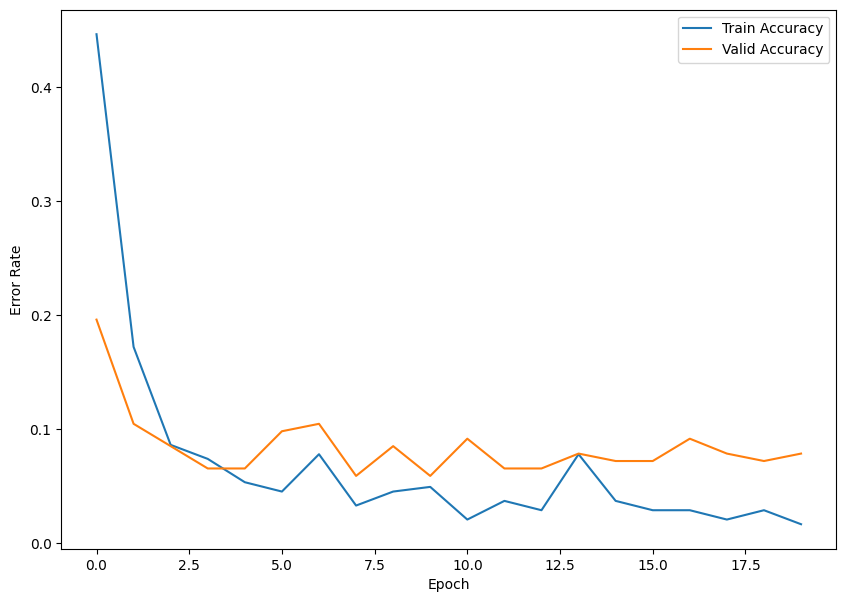

In [7]:
# 打印误差率曲线
y = [1 - x[1] for x in record]
z = [1 - x[2] for x in record]
plt.figure(figsize = (10, 7))
plt.plot(y, label='Train Accuracy')
plt.plot(z, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()

 ## 可视化

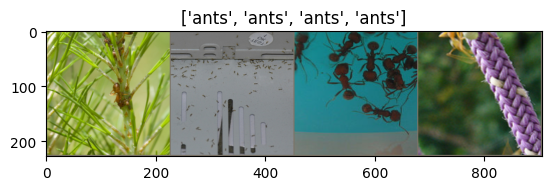

In [8]:
def imshow(inp, title=None):
    # 将一张图打印显示出来，inp为一个张量，title为显示在图像上的文字
    
    #一般的张量格式为：channels*image_width*image_height
    #而一般的图像为image_width*image_height*channels所以，需要将channels转换到最后一个维度
    inp = inp.numpy().transpose((1, 2, 0)) 
    
    #由于在读入图像的时候所有图像的色彩都标准化了，因此我们需要先调回去
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    #将图像绘制出来
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


#获取第一个图像batch和标签
images, labels = next(iter(train_loader))

# 将这个batch中的图像制成表格绘制出来
out = torchvision.utils.make_grid(images)

imshow(out, title=[train_dataset.classes[x] for x in labels])
plt.show()

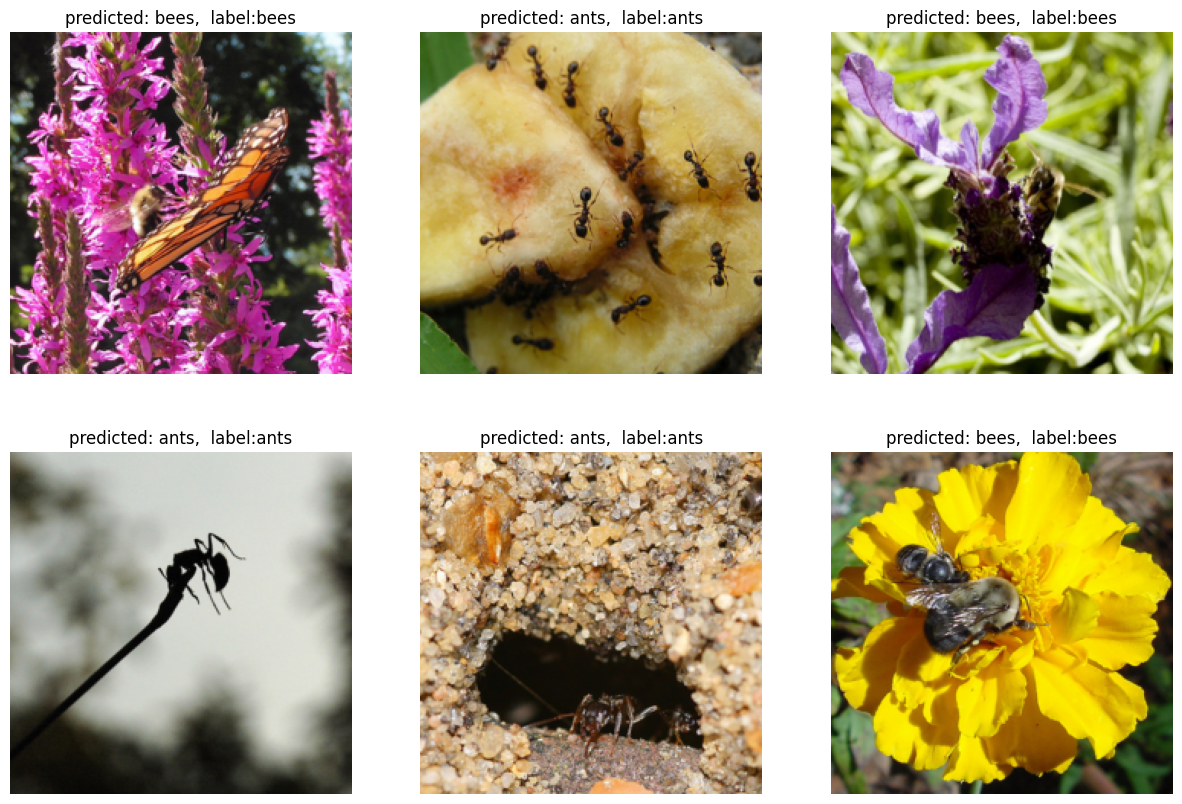

In [9]:
# 将预训练的模型用于测试数据，打印其分类效果
def visualize_model(model, num_images=6, row=2):
    images_so_far = 0
    fig = plt.figure(figsize=(15,10))

    for i, data in enumerate(val_loader):
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(row,num_images//row, images_so_far)
            ax.axis('off')
            
            ax.set_title('predicted: {},  label:{}'.format(val_dataset.classes[preds[j]], 
                                                           val_dataset.classes[labels[j]]))
            imshow(data[0][j])

            if images_so_far == num_images:
                plt.ioff()
                plt.show()
                return
visualize_model(net)



实验总结：迁移模型具有良好的基础识别特征能力，仅需少量和样本和训练就能达到比较好的效果，但是在样本量小的情况下，训练好的模型仍然不能识别一些缺乏特征的图片，如蜂巢中成群但每只都很小的蜜蜂。